# Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll work with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's website.

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, you'll create a few different machine learning models and evaluate their performance.

# Imports

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
plt.style.use('fivethirtyeight')

# Read data

In [2]:
bike_rentals = pd.read_csv("hour.csv")

# FUNCTIONS

In [47]:
def distribution_plot(df, column, title, with_mean=True):
    
    plt.figure(figsize=(20,10))
    df[column].plot.hist()
    if with_mean:
        plt.axvline(df[column].mean(), color='black', label='mean')
    plt.title(title)
    plt.legend()
    
def corr_plot(df, column, title, rotation=90):
    plt.figure(figsize=(20,10))
    df.corr()[column].plot()
    plt.xticks(rotation=rotation)
    plt.title(title)
    plt.legend()
    
def hours_transformation(hour):
    """ 1 if the hour is from 6 to 12
        2 if the hour is from 12 to 18
        3 if the hour is from 18 to 24
        4 if the hour is from 0 to 6 """
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3
    
def value_counts_plot(df, column, title):
    plt.figure(figsize=(20,10))
    round(df[column].value_counts(dropna=False, normalize=True)*100, 2).plot(kind="bar")
    plt.title(title)
    plt.xlabel('%')
    plt.ylabel('Value')
    plt.legend()        

def predict_analysis(train_df, test_df, model_columns, column_to_predict, model="LR"):
    mse = []
    if model == "LR":
        reg = LinearRegression()
        reg.fit(train_df[model_columns], train_df[column_to_predict])
        predictions = reg.predict(test_df[model_columns])
        mse = np.mean((predictions - test_df[column_to_predict]) **2)
        print("MSE:", mse)
        
    if model == "RF" or model == "DT":
        models = []
        for i in range(1, 10):
            if model == "DT":
                dt = DecisionTreeRegressor(min_samples_leaf=i)
            else:
                dt = RandomForestRegressor(min_samples_leaf=i)
            dt.fit(train_df[model_columns], train_df[column_to_predict])
            models.append(dt)
        
        for i in range(1, 10):
            dt = models[i-1]
            predictions = dt.predict(test_df[model_columns])
            m = np.mean((predictions - test_df[column_to_predict]) ** 2)
            print("DT WIHT ", i, "SAMPLE LEAF ERROR", m)
            mse.append(m)        
    return mse

# EDA

In [4]:
bike_rentals

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


## TOTAL NUMBER OF BIKE RENTALS (CNT) DISTRIBUTION

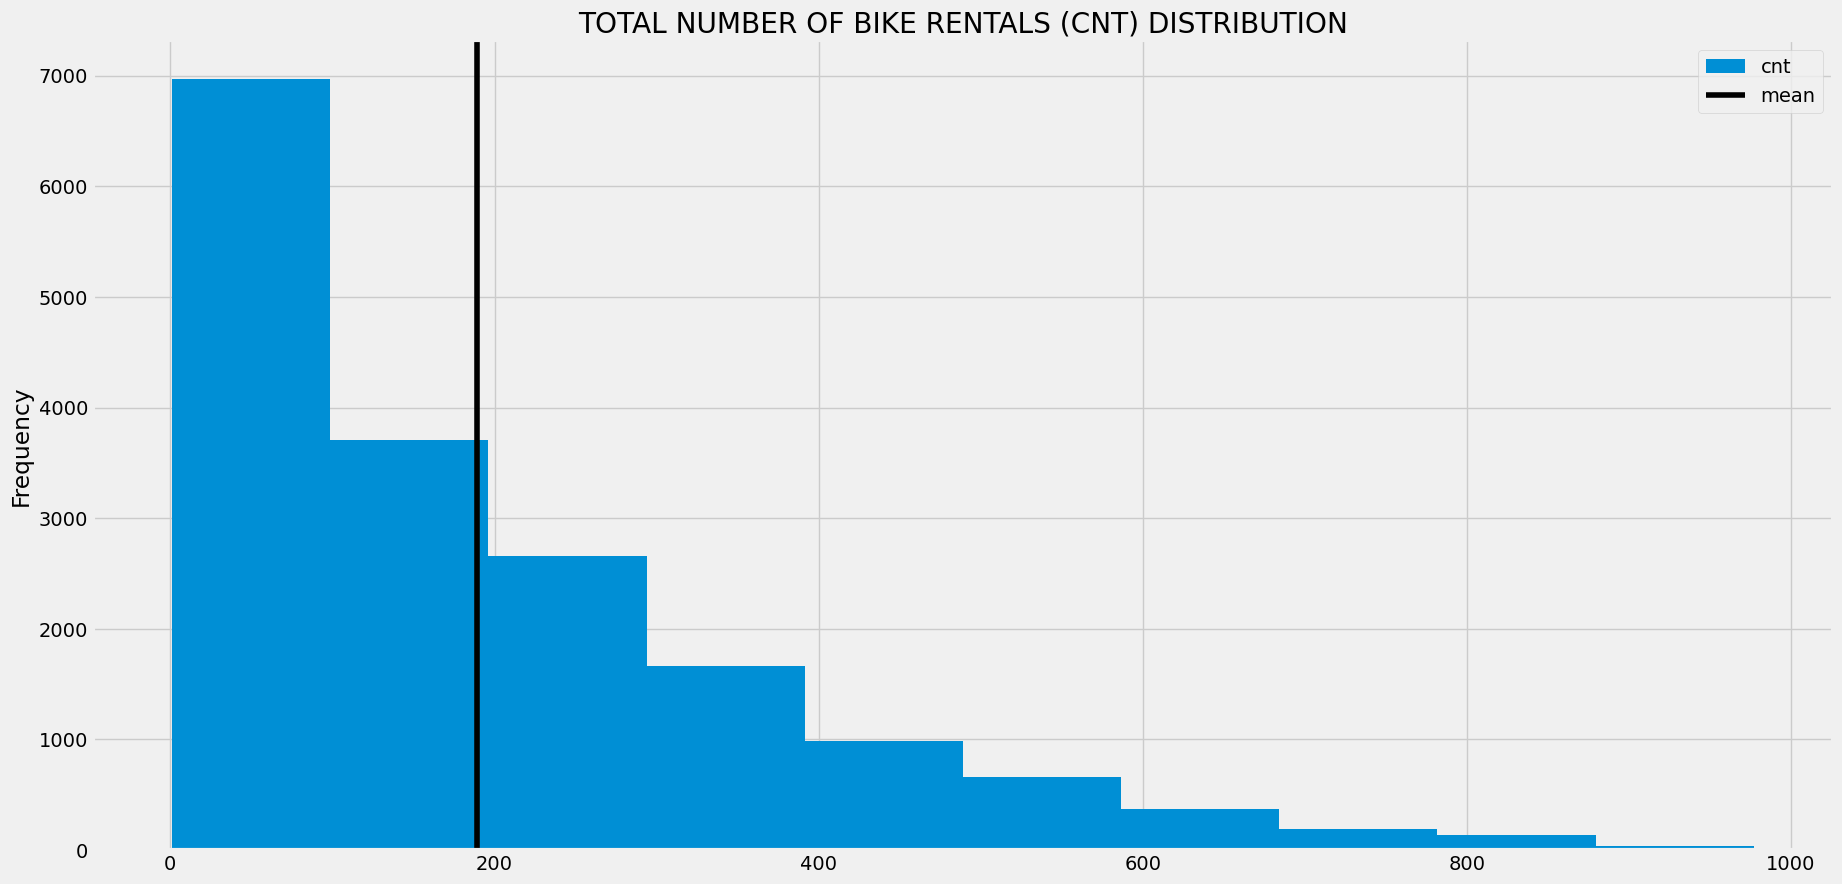

In [5]:
distribution_plot(bike_rentals, "cnt", "TOTAL NUMBER OF BIKE RENTALS (CNT) DISTRIBUTION", with_mean=True)

From the previous chart we observe that the average bike rentals is nearby 200.

## CNT CORRELATION

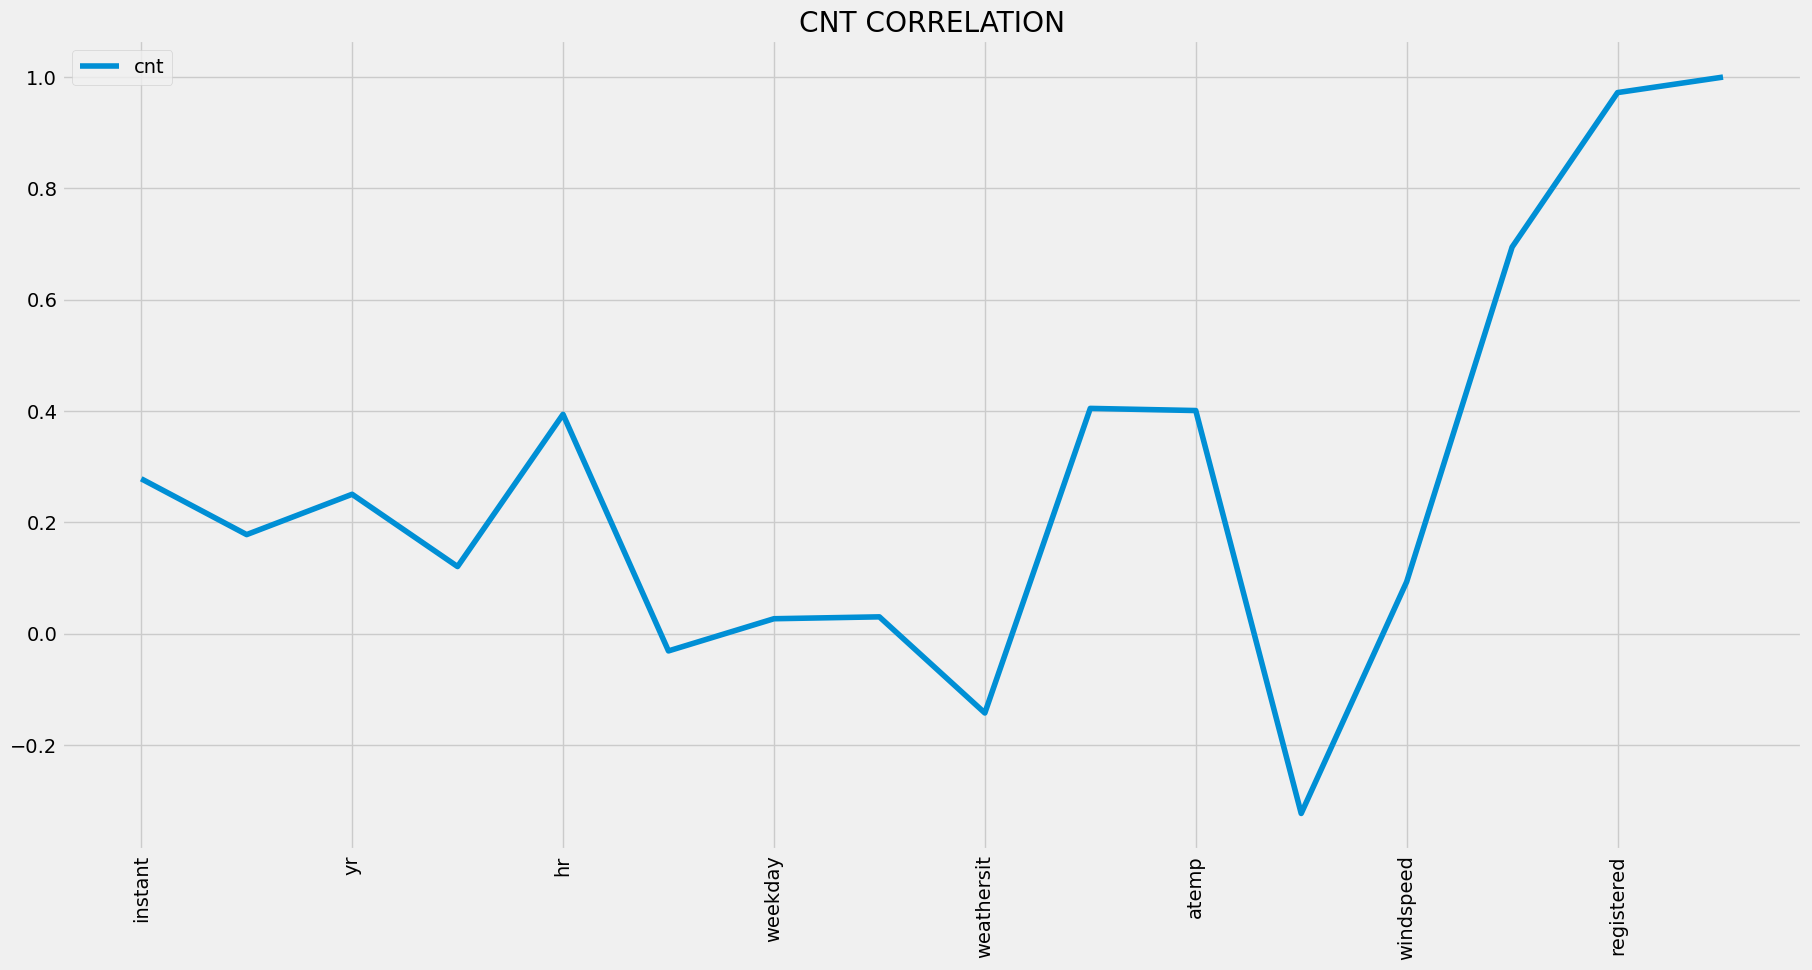

In [6]:
corr_plot(bike_rentals, "cnt", "CNT CORRELATION", rotation=90)

The most correlated columns to **CNT** are:
- Registered
- Windspeed
- Atemp
- Weathersit
- Hr

## TOTAL NUMBER OF BIKE RENTALS PER HOUR

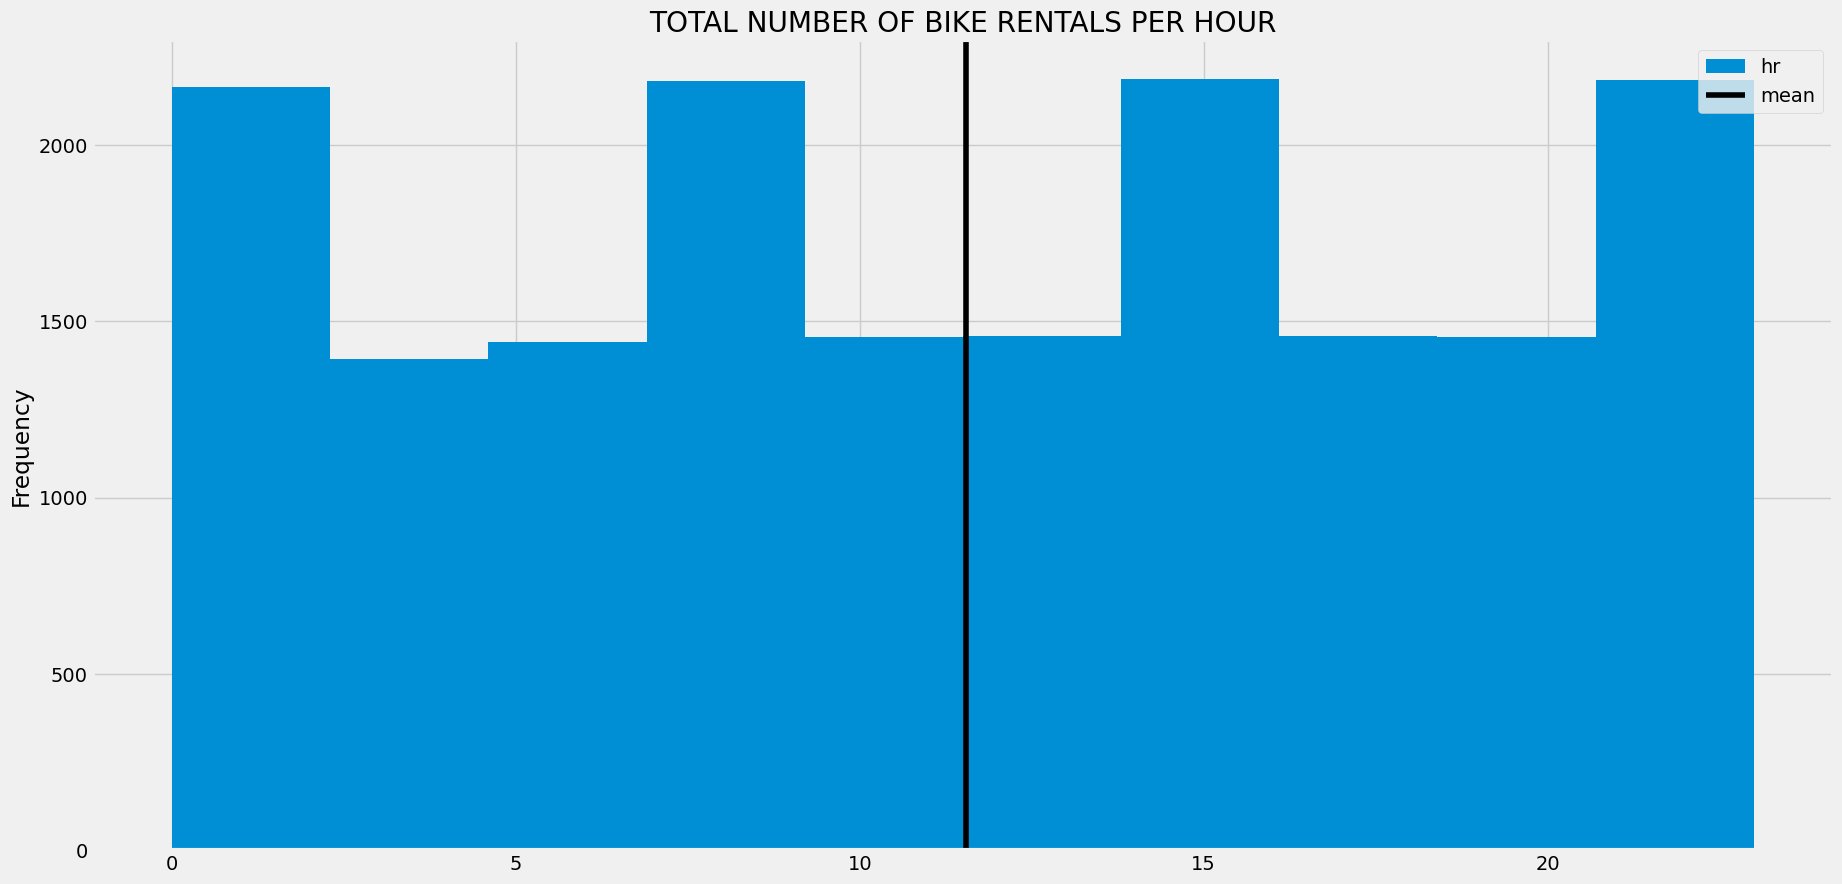

In [7]:
distribution_plot(bike_rentals, "hr", "TOTAL NUMBER OF BIKE RENTALS PER HOUR", with_mean=True)

# FEATURE ENGINEERING

## Time Label

The **hr** column in **bike_rentals** contains the hours during which bikes are rented, from **1** to **24**. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for **morning, afternoon, evening, and night**. This bundles similar times together, enabling the model to make better decisions.

In [8]:
bike_rentals["time_label"] = bike_rentals["hr"].apply(hours_transformation)

In [9]:
bike_rentals["time_label"].value_counts(dropna=False)

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

### Time Label Value Counts

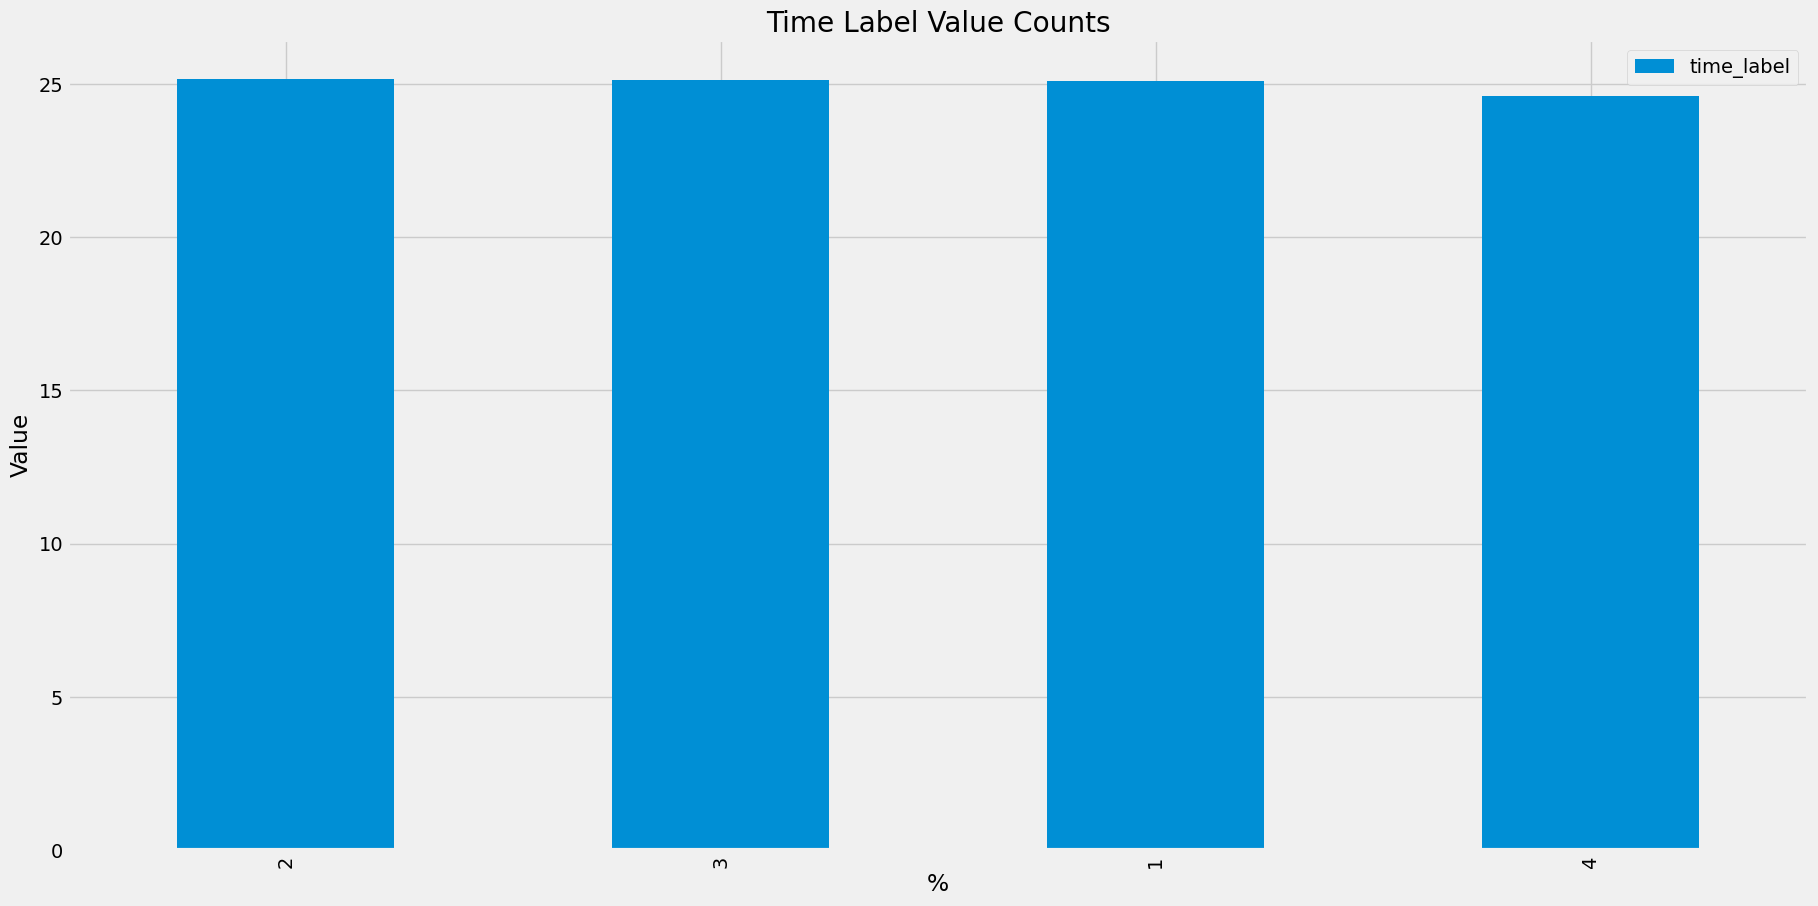

In [10]:
value_counts_plot(bike_rentals, "time_label", "Time Label Value Counts")

# Prediction Algorithms

## Error Metric Definition

The **mean squared error** metric makes the most sense to evaluate our error. **MSE** works on continuous numeric data, which fits our data quite well.

## Train Test Split

In [11]:
train = bike_rentals.sample(frac=.8)

In [13]:
train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
2480,2481,2011-04-18,2,0,4,6,0,1,1,1,0.40,0.4091,0.82,0.0000,3,51,54,1
13570,13571,2012-07-24,3,1,7,15,0,2,1,1,0.82,0.7727,0.49,0.2985,73,212,285,2
3447,3448,2011-05-28,2,0,5,13,0,6,0,1,0.72,0.6818,0.62,0.2239,168,217,385,2
5387,5388,2011-08-17,3,0,8,9,0,3,1,1,0.74,0.6667,0.48,0.0896,31,178,209,1
12957,12958,2012-06-29,3,1,6,2,0,5,1,1,0.72,0.6667,0.58,0.1940,3,15,18,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,2589,2011-04-22,2,0,4,18,0,5,1,3,0.32,0.3030,0.93,0.2239,4,47,51,3
11571,11572,2012-05-02,2,1,5,8,0,3,1,2,0.56,0.5303,0.88,0.0000,26,640,666,1
5268,5269,2011-08-12,3,0,8,10,0,5,1,1,0.74,0.6515,0.33,0.1045,44,86,130,1
1573,1574,2011-03-11,1,0,3,0,0,5,1,2,0.34,0.3485,1.00,0.0896,0,6,6,4


In [12]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [14]:
test

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
11,12,2011-01-01,1,0,1,11,0,6,0,1,0.36,0.3333,0.81,0.2836,26,30,56,1
15,16,2011-01-01,1,0,1,15,0,6,0,2,0.44,0.4394,0.77,0.2985,40,70,110,2
16,17,2011-01-01,1,0,1,16,0,6,0,2,0.42,0.4242,0.82,0.2985,41,52,93,2
19,20,2011-01-01,1,0,1,19,0,6,0,3,0.42,0.4242,0.88,0.2537,6,31,37,3
29,30,2011-01-02,1,0,1,6,0,0,0,3,0.42,0.4242,0.77,0.2985,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17357,17358,2012-12-31,1,1,12,2,0,1,1,1,0.16,0.1667,0.59,0.1642,3,8,11,4
17361,17362,2012-12-31,1,1,12,6,0,1,1,1,0.16,0.1667,0.64,0.1642,0,40,40,1
17363,17364,2012-12-31,1,1,12,8,0,1,1,1,0.14,0.1515,0.69,0.1343,9,187,196,1
17369,17370,2012-12-31,1,1,12,14,0,1,1,2,0.28,0.2727,0.45,0.2239,62,185,247,2


## Exclusion Columns

In this part we will remove columns that dont bring any information to the dataset or also is the information that we want to predict:
- cnt
- casual
- dteday
- registered

In [19]:
predictors = train.columns.tolist()
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

## Prediction

### Linear Regression

In [45]:
mse = predict_analysis(train, test, predictors, "cnt", model="LR")

MSE: 17676.44152472376


#### Error Overview

The error is very high. This may be due to the fact that the data has a few extremely high rental counts but on the other hand mostly low counts. Larger errors are penalized more with MSE, which lead to a higher total error.

### Decision Tree Regressor

In [48]:
mse = predict_analysis(train, test, predictors, "cnt", model="DT")

DT WIHT  1 SAMPLE LEAF ERROR 2710.405926352129
DT WIHT  2 SAMPLE LEAF ERROR 2528.693477496479
DT WIHT  3 SAMPLE LEAF ERROR 2328.6897279759532
DT WIHT  4 SAMPLE LEAF ERROR 2424.654438702116
DT WIHT  5 SAMPLE LEAF ERROR 2396.017623475941
DT WIHT  6 SAMPLE LEAF ERROR 2370.1688105795256
DT WIHT  7 SAMPLE LEAF ERROR 2403.96756337371
DT WIHT  8 SAMPLE LEAF ERROR 2330.126132745885
DT WIHT  9 SAMPLE LEAF ERROR 2388.2585625353645


#### Error Overview

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

### Random Forest Error

In [49]:
mse = predict_analysis(train, test, predictors, "cnt", model="RF")

DT WIHT  1 SAMPLE LEAF ERROR 1411.4362758055224
DT WIHT  2 SAMPLE LEAF ERROR 1407.4685220941044
DT WIHT  3 SAMPLE LEAF ERROR 1457.632732756504
DT WIHT  4 SAMPLE LEAF ERROR 1505.5015841816592
DT WIHT  5 SAMPLE LEAF ERROR 1548.0972675538542
DT WIHT  6 SAMPLE LEAF ERROR 1627.2760631798903
DT WIHT  7 SAMPLE LEAF ERROR 1638.6205313157795
DT WIHT  8 SAMPLE LEAF ERROR 1723.859360564219
DT WIHT  9 SAMPLE LEAF ERROR 1771.6572013833345


#### Fit

#### Error Overview

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.

### Predict Casual

In [50]:
mse = predict_analysis(train, test, predictors, "casual", model="LR")

MSE: 1313.447144812434


In [51]:
mse = predict_analysis(train, test, predictors, "casual", model="DT")

DT WIHT  1 SAMPLE LEAF ERROR 353.33342922899885
DT WIHT  2 SAMPLE LEAF ERROR 319.1196298427312
DT WIHT  3 SAMPLE LEAF ERROR 319.6714186165454
DT WIHT  4 SAMPLE LEAF ERROR 315.01660486288887
DT WIHT  5 SAMPLE LEAF ERROR 317.6709123432436
DT WIHT  6 SAMPLE LEAF ERROR 299.33306774777196
DT WIHT  7 SAMPLE LEAF ERROR 306.5741860897186
DT WIHT  8 SAMPLE LEAF ERROR 312.5111857278546
DT WIHT  9 SAMPLE LEAF ERROR 305.2321060975188


In [52]:
mse = predict_analysis(train, test, predictors, "casual", model="RF")

DT WIHT  1 SAMPLE LEAF ERROR 177.66826294591482
DT WIHT  2 SAMPLE LEAF ERROR 184.723704948244
DT WIHT  3 SAMPLE LEAF ERROR 190.18398970044723
DT WIHT  4 SAMPLE LEAF ERROR 195.95301555246135
DT WIHT  5 SAMPLE LEAF ERROR 205.39172013199777
DT WIHT  6 SAMPLE LEAF ERROR 216.02486703061987
DT WIHT  7 SAMPLE LEAF ERROR 224.62948863057682
DT WIHT  8 SAMPLE LEAF ERROR 232.2532279181972
DT WIHT  9 SAMPLE LEAF ERROR 241.46347510419582


For the **casual** feature the **mse** is to much lower.

### Predict Registered

In [53]:
mse = predict_analysis(train, test, predictors, "registered", model="LR")

MSE: 13460.786852654752


In [54]:
mse = predict_analysis(train, test, predictors, "registered", model="DT")

DT WIHT  1 SAMPLE LEAF ERROR 1847.042002301496
DT WIHT  2 SAMPLE LEAF ERROR 1646.3432265694898
DT WIHT  3 SAMPLE LEAF ERROR 1583.1550155830419
DT WIHT  4 SAMPLE LEAF ERROR 1614.5306388689908
DT WIHT  5 SAMPLE LEAF ERROR 1623.476992286001
DT WIHT  6 SAMPLE LEAF ERROR 1565.8343197537438
DT WIHT  7 SAMPLE LEAF ERROR 1543.165305194087
DT WIHT  8 SAMPLE LEAF ERROR 1593.820604474061
DT WIHT  9 SAMPLE LEAF ERROR 1635.8999053608359


In [55]:
mse = predict_analysis(train, test, predictors, "registered", model="RF")

DT WIHT  1 SAMPLE LEAF ERROR 939.1191000287681
DT WIHT  2 SAMPLE LEAF ERROR 988.2777945063793
DT WIHT  3 SAMPLE LEAF ERROR 1039.2035913387376
DT WIHT  4 SAMPLE LEAF ERROR 1098.0289656499226
DT WIHT  5 SAMPLE LEAF ERROR 1139.1757211953252
DT WIHT  6 SAMPLE LEAF ERROR 1177.1357365019326
DT WIHT  7 SAMPLE LEAF ERROR 1236.7128126845141
DT WIHT  8 SAMPLE LEAF ERROR 1272.4686435832798
DT WIHT  9 SAMPLE LEAF ERROR 1306.9088099101336


For the **registered** column the mean squared error is lower than for **cnt** but is much higher than for casual.

https://nbviewer.org/urls/community.dataquest.io/uploads/short-url/9bucZmmgOGJMecx1SpoRM2wBMu.ipynb